In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

# Preprocessing


In [1]:
# Handling Outliers

from scipy import stats

def detect_outliers_iqr(df, columns):
    """Deteksi outlier menggunakan IQR method"""
    outlier_indices = set()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definisi outlier: nilai di luar Q1 - 1.5*IQR dan Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identifikasi outlier
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        col_outliers = df[outlier_mask].index.tolist()
        outlier_indices.update(col_outliers)
        
        print(f"{col}: {len(col_outliers)} outliers detected")
    
    return list(outlier_indices)

def handle_outliers_winsorization(df, columns, limits=(0.05, 0.05)):
    """Handle outliers dengan winsorization (clipping ke percentile tertentu)"""
    df_processed = df.copy()
    
    for col in columns:
        # Hitung percentile untuk clipping
        lower_percentile = df[col].quantile(limits[0])
        upper_percentile = df[col].quantile(1 - limits[1])
        
        # Clip outliers
        df_processed[col] = df_processed[col].clip(lower_percentile, upper_percentile)
        
    return df_processed

# Kolom numerik untuk outlier detection
numeric_columns = ['Average_Temperature_C', 'Total_Precipitation_mm', 'CO2_Emissions_MT', 
                   'Crop_Yield_MT_per_HA', 'Irrigation_Access_%', 'Pesticide_Use_KG_per_HA',
                   'Fertilizer_Use_KG_per_HA', 'Soil_Health_Index', 'Economic_Impact_Million_USD']


# Feature Engineering



In [2]:
categorical_columns = ['Country', 'Region', 'Crop_Type', 'Adaptation_Strategies']

In [3]:
# Target Encoding 
from sklearn.model_selection import KFold

def target_encoding(X_train, X_test, y_train, categorical_columns, k=5):
    """
    Implementasi Target Encoding dengan K-Fold Cross Validation
    untuk menghindari overfitting
    """
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    
    # Reset index 
    X_train_encoded = X_train_encoded.reset_index(drop=True)
    X_test_encoded = X_test_encoded.reset_index(drop=True)
    y_train_reset = y_train.reset_index(drop=True)
    
    # K-Fold
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for col in categorical_columns:
        # Inisialisasi kolom baru untuk training
        X_train_encoded[f'{col}_target_encoded'] = 0.0
        
        # Cross-validation encoding 
        for train_idx, val_idx in kfold.split(X_train_encoded):
            train_fold_data = pd.DataFrame({
                col: X_train_encoded.iloc[train_idx][col],
                'target': y_train_reset.iloc[train_idx]
            })
            target_means = train_fold_data.groupby(col)['target'].mean()
            
            X_train_encoded.loc[val_idx, f'{col}_target_encoded'] = \
                X_train_encoded.iloc[val_idx][col].map(target_means).fillna(y_train_reset.mean())
        
        full_data = pd.DataFrame({
            col: X_train_encoded[col],
            'target': y_train_reset
        })
        target_means_full = full_data.groupby(col)['target'].mean()
        X_test_encoded[f'{col}_target_encoded'] = \
            X_test_encoded[col].map(target_means_full).fillna(y_train_reset.mean())
        
        X_train_encoded = X_train_encoded.drop(col, axis=1)
        X_test_encoded = X_test_encoded.drop(col, axis=1)
    
    return X_train_encoded, X_test_encoded

# Data Preparation

In [4]:
def load_data():
    data_dir = 'input/'

    df = pd.read_csv(data_dir + 'climate_change_impact.csv')
    return df

In [7]:
df = load_data()

In [13]:
df

,Year,Country,Region,Crop_Type,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Crop_Yield_MT_per_HA,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,Adaptation_Strategies,Economic_Impact_Million_USD
0,2001,India,West Bengal,Corn,1.55,447.06,15.22,1.737,8,14.54,10.08,14.78,83.25,Water Management,808.13
1,2024,China,North,Corn,3.23,2913.57,29.82,1.737,8,11.05,33.06,23.25,54.02,Crop Rotation,616.22
2,2001,France,Ile-de-France,Wheat,21.11,1301.74,25.75,1.719,5,84.42,27.41,65.53,67.78,Water Management,796.96
3,2001,Canada,Prairies,Coffee,27.85,1154.36,13.91,3.890,5,94.06,14.38,87.58,91.39,No Adaptation,790.32
4,1998,India,Tamil Nadu,Sugarcane,2.19,1627.48,11.81,1.080,9,95.75,44.35,88.08,49.61,Crop Rotation,401.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2022,France,Nouvelle-Aquitaine,Cotton,30.48,685.93,17.64,3.033,9,27.56,41.96,10.95,43.41,No Adaptation,1483.06
9996,1999,Australia,Queensland,Soybeans,9.53,2560.38,10.68,2.560,4,77.02,5.45,82.32,59.39,No Adaptation,829.61
9997,2000,Argentina,Patagonia,Coffee,31.92,357.76,26.01,1.161,10,78.53,11.94,26.00,41.46,Water Management,155.99
9998,1996,Brazil,Southeast,Soybeans,13.95,1549.52,17.31,3.348,2,42.65,44.71,25.07,75.10,Crop Rotation,1613.90


=== OUTLIER DETECTION ===
Average_Temperature_C: 0 outliers detected
Total_Precipitation_mm: 0 outliers detected
CO2_Emissions_MT: 0 outliers detected
Crop_Yield_MT_per_HA: 0 outliers detected
Irrigation_Access_%: 0 outliers detected
Pesticide_Use_KG_per_HA: 0 outliers detected
Fertilizer_Use_KG_per_HA: 0 outliers detected
Soil_Health_Index: 0 outliers detected
Economic_Impact_Million_USD: 177 outliers detected

Total outlier records: 177 (1.77%)


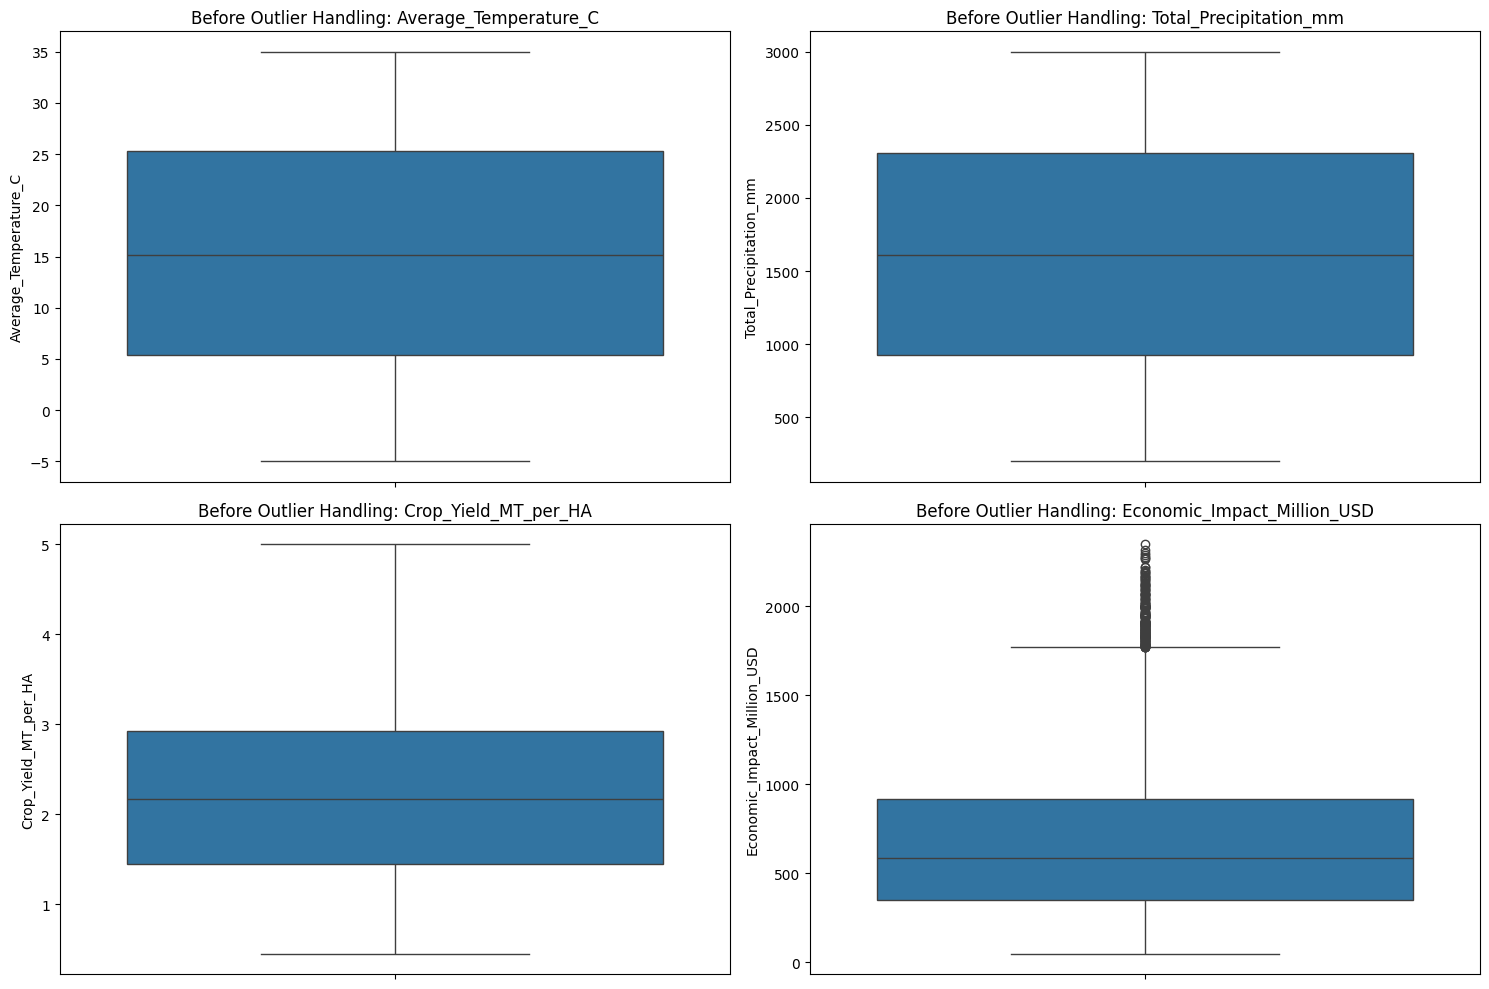

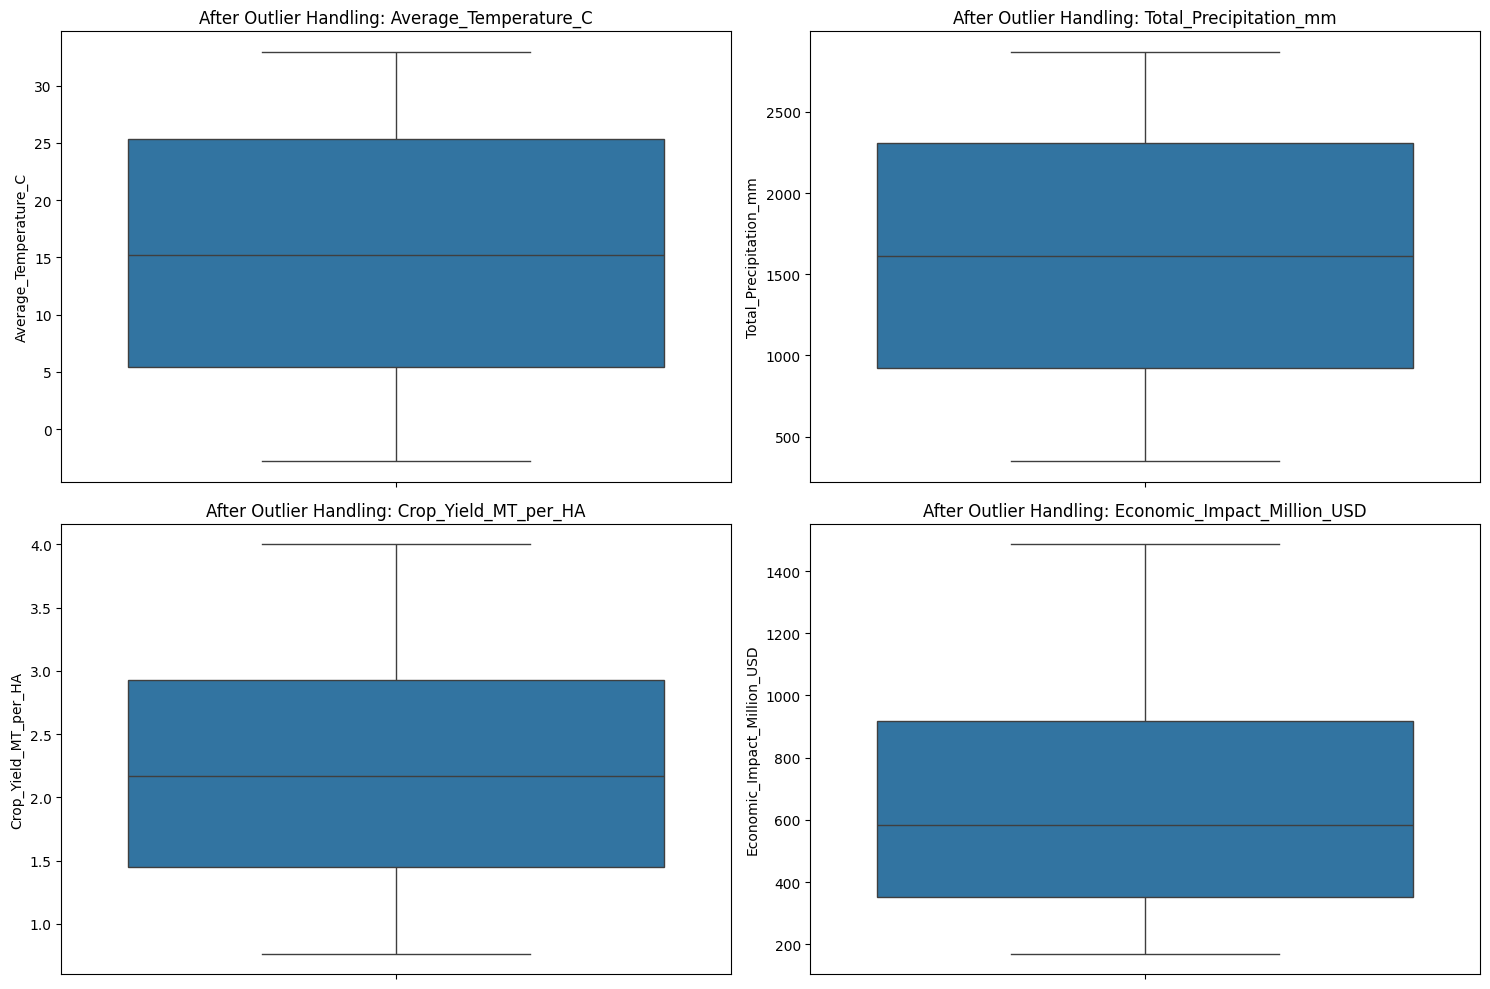

=== OUTLIER HANDLING COMPLETED ===


In [8]:
# Deteksi outliers
print("=== OUTLIER DETECTION ===")
outlier_indices = detect_outliers_iqr(df, numeric_columns)
print(f"\nTotal outlier records: {len(outlier_indices)} ({len(outlier_indices)/len(df)*100:.2f}%)")

# Visualisasi sebelum handling outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Average_Temperature_C', 'Total_Precipitation_mm', 'Crop_Yield_MT_per_HA', 'Economic_Impact_Million_USD'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Before Outlier Handling: {col}')
plt.tight_layout()
plt.show()

# Handle outliers dengan winsorization
df_processed = handle_outliers_winsorization(df, numeric_columns)

# Visualisasi setelah handling outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Average_Temperature_C', 'Total_Precipitation_mm', 'Crop_Yield_MT_per_HA', 'Economic_Impact_Million_USD'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_processed[col])
    plt.title(f'After Outlier Handling: {col}')
plt.tight_layout()
plt.show()

print("=== OUTLIER HANDLING COMPLETED ===")

In [9]:
X = df_processed.drop(['Crop_Yield_MT_per_HA'], axis=1)
y = df_processed['Crop_Yield_MT_per_HA']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
X_train

,Year,Country,Region,Crop_Type,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,Adaptation_Strategies,Economic_Impact_Million_USD
9254,2023,USA,Midwest,Barley,-2.8105,2025.110,13.39,1,86.95,7.75,76.86,81.11,Drought-resistant Crops,304.990
1561,2018,China,Central,Rice,8.9300,2656.190,8.49,0,23.39,26.01,54.98,50.48,Organic Farming,821.470
1670,1997,USA,South,Vegetables,16.6500,2307.290,26.83,5,94.89,33.32,40.51,69.28,Organic Farming,1131.220
6087,1990,Nigeria,North West,Vegetables,30.4500,2415.670,19.99,2,75.81,15.38,22.87,56.17,No Adaptation,169.627
6669,2020,Brazil,Northeast,Cotton,-2.8105,2744.130,17.37,0,24.21,16.54,37.89,52.40,Drought-resistant Crops,349.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2013,Russia,Volga,Fruits,32.9605,2246.090,21.13,5,82.22,9.34,46.40,33.58,Drought-resistant Crops,1184.410
5191,1993,Nigeria,North West,Rice,27.7500,2123.630,3.37,10,73.54,36.15,21.27,81.22,Crop Rotation,633.140
5390,2009,USA,South,Soybeans,-0.5900,1383.130,17.97,4,50.84,23.16,45.37,49.64,Crop Rotation,664.770
860,1999,USA,West,Cotton,27.6600,2604.800,6.73,1,39.02,17.40,39.93,47.26,Crop Rotation,169.627


In [12]:
X_train_encoded, X_test_encoded = target_encoding(X_train, X_test, y_train, categorical_columns)


# Model Evaluation

In [13]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)

LinearRegression()

In [14]:
print("Intercept:", model.intercept_)
print("Coefficients:")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef}")

Intercept: 0.936566320519644
Coefficients:
Year: 0.0006493291986042366
Country: 0.01122911659636145
Region: 2.227619158189781e-05
Crop_Type: -0.004744525467397644
Average_Temperature_C: -0.0009373951223423642
Total_Precipitation_mm: -7.391968508472802e-05
CO2_Emissions_MT: 0.00012922257604299547
Extreme_Weather_Events: -1.4898187071967623e-05
Irrigation_Access_%: -0.00019193704767897984
Pesticide_Use_KG_per_HA: 0.0017177617230916564
Fertilizer_Use_KG_per_HA: -0.36433016906658616
Soil_Health_Index: 0.02396762368745893
Adaptation_Strategies: 0.08957045893020366
Economic_Impact_Million_USD: -0.321506769896174


In [15]:
y_pred = model.predict(X_test_encoded)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

MSE: 0.40864117642979536
R2 Score: 0.564159758256066


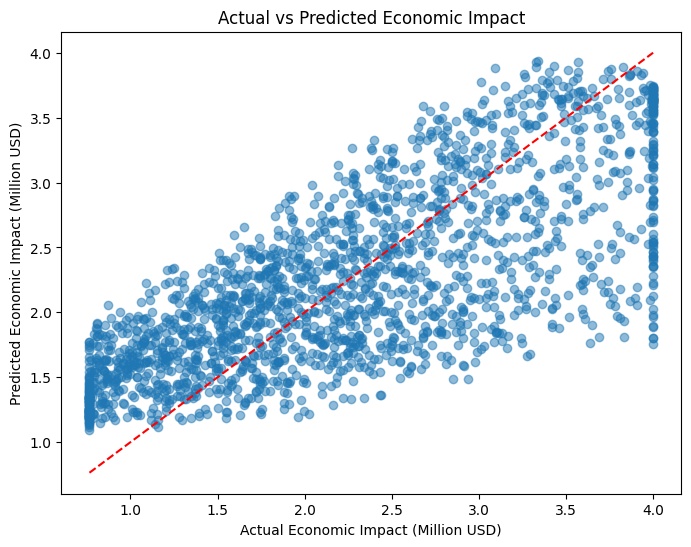

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Economic Impact (Million USD)')
plt.ylabel('Predicted Economic Impact (Million USD)')
plt.title('Actual vs Predicted Economic Impact')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Garis y=x
plt.show()

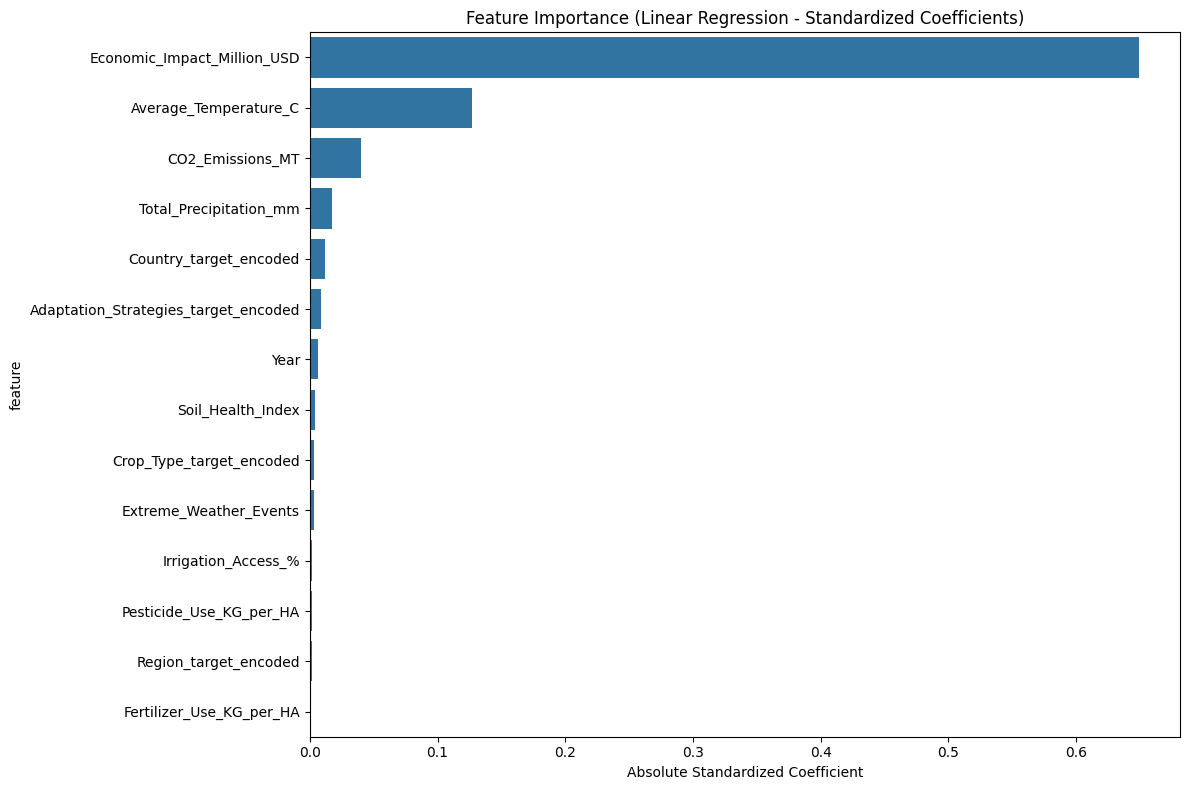

Top 10 Features (Standardized Coefficients):
                                 feature  standardized_coef  \
9            Economic_Impact_Million_USD           0.648814   
1                  Average_Temperature_C           0.126994   
3                       CO2_Emissions_MT          -0.040281   
2                 Total_Precipitation_mm           0.017636   
10                Country_target_encoded          -0.012303   
13  Adaptation_Strategies_target_encoded          -0.008729   
0                                   Year           0.006519   
8                      Soil_Health_Index          -0.003830   
12              Crop_Type_target_encoded           0.003582   
4                 Extreme_Weather_Events          -0.002965   

    abs_standardized_coef  
9                0.648814  
1                0.126994  
3                0.040281  
2                0.017636  
10               0.012303  
13               0.008729  
0                0.006519  
8                0.003830  
12       

In [17]:
# Standarisasi 

from sklearn.preprocessing import StandardScaler

# Standardize fitur untuk mendapatkan koefisien yang comparable
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Train model dengan standardized features
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)

# Feature importance dengan standardized coefficients
plt.figure(figsize=(12, 8))

lr_standardized_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'standardized_coef': model_scaled.coef_,
    'abs_standardized_coef': np.abs(model_scaled.coef_)
}).sort_values('abs_standardized_coef', ascending=False)

sns.barplot(data=lr_standardized_importance.head(15), x='abs_standardized_coef', y='feature')
plt.title('Feature Importance (Linear Regression - Standardized Coefficients)')
plt.xlabel('Absolute Standardized Coefficient')
plt.tight_layout()
plt.show()

print("Top 10 Features (Standardized Coefficients):")
print(lr_standardized_importance.head(10))

# XGboost Model

In [18]:
# XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train_encoded, y_train)

# Prediksi
y_pred_xgb = xgb_model.predict(X_test_encoded)

# Evaluasi
print('XGBoost Results:')
print('MSE:', mean_squared_error(y_test, y_pred_xgb))
print('R2 Score:', r2_score(y_test, y_pred_xgb))

XGBoost Results:
MSE: 0.3610222494511748
R2 Score: 0.6149481903648266


In [19]:
from catboost import CatBoostRegressor

# CatBoost Model
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    cat_features=categorical_columns
)

catboost_model.fit(X_train, y_train)

# Prediksi
y_pred_xgb = catboost_model.predict(X_test)

# Evaluasi
print('Catboost Results:')
print('MSE:', mean_squared_error(y_test, y_pred_xgb))
print('R2 Score:', r2_score(y_test, y_pred_xgb))

Catboost Results:
MSE: 0.37227351459608415
R2 Score: 0.6029480435281193


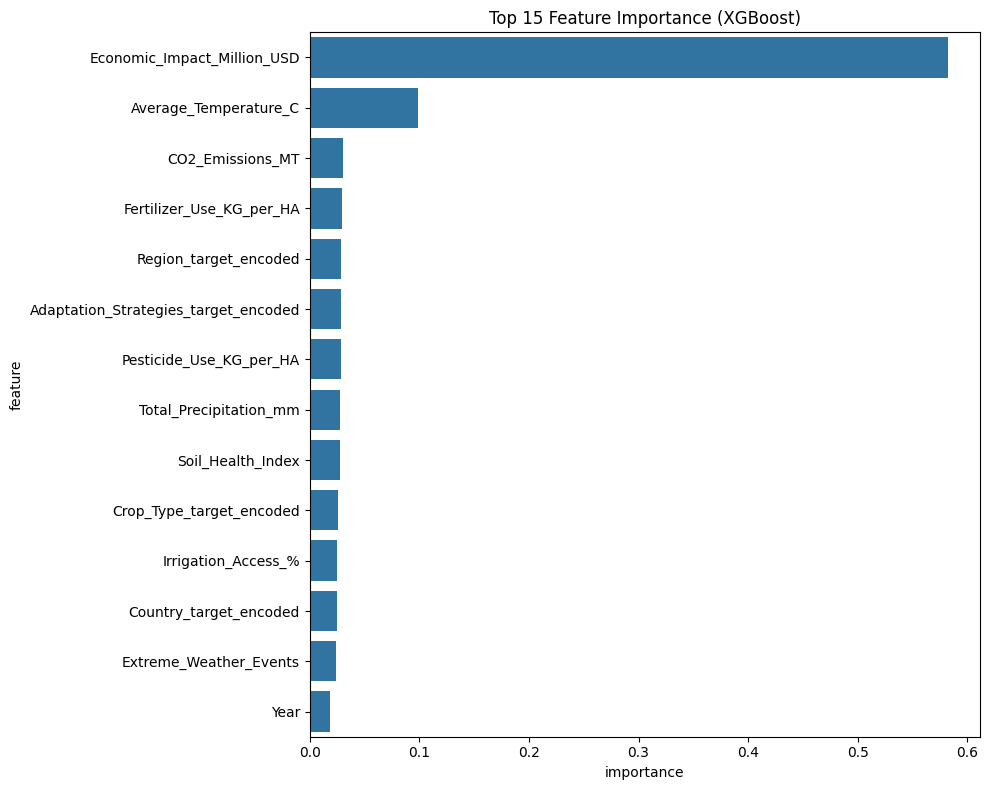

Top 10 Most Important Features:
                                 feature  importance
9            Economic_Impact_Million_USD    0.582454
1                  Average_Temperature_C    0.098947
3                       CO2_Emissions_MT    0.030009
7               Fertilizer_Use_KG_per_HA    0.029645
11                 Region_target_encoded    0.028922
13  Adaptation_Strategies_target_encoded    0.028626
6                Pesticide_Use_KG_per_HA    0.028492
2                 Total_Precipitation_mm    0.027479
8                      Soil_Health_Index    0.027462
12              Crop_Type_target_encoded    0.025642


In [20]:
# Feature Importance
plt.figure(figsize=(10, 8))
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 Most Important Features:")
print(feature_importance.head(10))

In [21]:
from sklearn.model_selection import GridSearchCV

# Parameter grid untuk tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Grid search
xgb_grid = XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Train dengan best parameters
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_encoded)

print('Tuned XGBoost Results:')
print('MSE:', mean_squared_error(y_test, y_pred_best))
print('R2 Score:', r2_score(y_test, y_pred_best))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best Score: 0.3440686940910555
Tuned XGBoost Results:
MSE: 0.34403899055105897
R2 Score: 0.6330618511791767


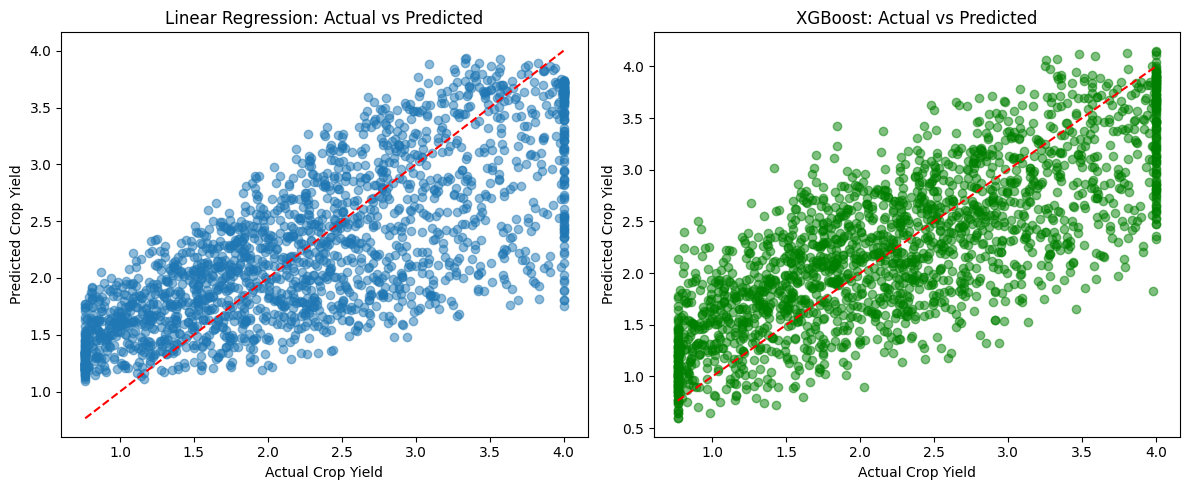

In [22]:
# Plot actual vs predicted untuk XGBoost
plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Crop Yield')
plt.ylabel('Predicted Crop Yield')
plt.title('Linear Regression: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
plt.xlabel('Actual Crop Yield')
plt.ylabel('Predicted Crop Yield')
plt.title('XGBoost: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.tight_layout()
plt.show()